
<h1 style="font-size: 0; line-height: 0; height: 0; margin: 0; padding: 0;">&#8203;</h1>
<h1 align="center" style="margin-top:10px">QBUS6810 Machine Learning for Business</h1>
<h2 align="center" style="margin-top:20px">Group Project</h2>
<br>

# Project Description
This project aims to support Olist in increasing customer satisfaction by building machine learning classification model to predict customer satisfaction based on the e-commerce data. The business question addressed in this project is "Can we predict whether a customer will be entirely satisfied with their purchasing experience, according to the information provided after their order is delivered?"

# Table of Contents
1. [Data Loading](#1.-Data-Loading)
2. [Data Merging](#2.-Data-Merging)
3. [Missing Value Checking](#3.-Missing-Value-Checking)
4. [Feature Engineering](#4.-Feature-Engineering-for-Predictors-and-Target-Variable)
5. [Machine Learning Algorithms](#5.-Macine-Learning-Algorithms)
5. [Conclusion](#Conclusion)


# 1. Data Loading

In [ ]:
# Install necessary packages if needed
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install mord
# !pip install shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=7b553abfe5225e21f7f6b5073e4417c12a145fda566996a6c2b0057cf9c623b7
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mord
import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss
)

In [ ]:
# Load the dataset
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

# 2. Data Merging

In [ ]:
# Aggregate to Order Level
# Step 1: Get number of unique payment types per order
payment_type_count = order_payments.groupby('order_id')['payment_type'].nunique()

# Step 2: Find main payment type (highest payment_value per order)
main_payment_type = (
    order_payments.sort_values(by=['order_id', 'payment_value'], ascending=[True, False])
    .drop_duplicates(subset='order_id')[['order_id', 'payment_type']]
    .set_index('order_id')
    .squeeze()
)

# Step 3: Get maximum number of installments per order
max_installments = order_payments.groupby('order_id')['payment_installments'].max()

# Step 4: Get total payment value per order
total_payment = order_payments.groupby('order_id')['payment_value'].sum()

# Step 5: Combine all into one DataFrame
agg_payments = pd.DataFrame({
    'number_of_payment_types': payment_type_count,
    'main_payment_type': main_payment_type,
    'max_installments': max_installments,
    'total_payment': total_payment
}).reset_index()

# Step 6: Done
print("✅ Aggregation complete. Shape:", agg_payments.shape)
print(agg_payments.head())

# Optional: Save to CSV
# agg_payments.to_csv("aggregated_order_payments.csv", index=False)


✅ Aggregation complete. Shape: (99440, 5)
                           order_id  number_of_payment_types  \
0  00010242fe8c5a6d1ba2dd792cb16214                        1   
1  00018f77f2f0320c557190d7a144bdd3                        1   
2  000229ec398224ef6ca0657da4fc703e                        1   
3  00024acbcdf0a6daa1e931b038114c75                        1   
4  00042b26cf59d7ce69dfabb4e55b4fd9                        1   

  main_payment_type  max_installments  total_payment  
0       credit_card                 2          72.19  
1       credit_card                 3         259.83  
2       credit_card                 5         216.87  
3       credit_card                 2          25.78  
4       credit_card                 3         218.04  


In [ ]:
# Merge Datasets
# Merge customers with orders
merged_df = pd.merge(customers, orders, on='customer_id', how='left')

# Merge with order_reviews
merged_df = pd.merge(merged_df, reviews, on='order_id', how='left')

# Merge with order_items
merged_df = pd.merge(merged_df, order_items, on='order_id', how='left')

# Merge with products
merged_df = pd.merge(merged_df, products, on='product_id', how='left')

# Display the first few rows of the merged dataframe
print(merged_df.shape)

# Merge with order_payments
# merged_df = pd.merge(merged_df, order_payments, on='order_id', how='left')

# # Merge with geolocation
# merged_df = pd.merge(merged_df, geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

# save to .csv file
# merged_df.to_csv("merged_df.csv", index=False)


(114092, 32)


In [ ]:
# Feature Engineering
# Convert dates
date_cols = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

# Feature engineering
merged_df['delivery_days'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days
merged_df['is_late'] = (merged_df['order_delivered_customer_date'] > merged_df['order_estimated_delivery_date']).astype(int)

# Aggregation
agg_df = merged_df.groupby('order_id').agg({
    'customer_unique_id': 'first',
    'order_item_id': 'max',  # total_items
    'product_id': pd.Series.nunique,  # total_unique_products
    'product_category_name': pd.Series.nunique,  # total_categories
    'seller_id': pd.Series.nunique,  # total_sellers
    'price': 'sum',
    'freight_value': 'sum',
    'product_name_lenght': 'mean',
    'product_description_lenght': 'mean',
    'product_photos_qty': 'mean',
    'delivery_days': 'mean',
    'is_late': 'max',
    'customer_city': 'first',
    'customer_state': 'first',
    'order_status': 'first',
    'order_purchase_timestamp': 'first',
    'order_approved_at': 'first',
    'order_delivered_carrier_date': 'first',
    'order_delivered_customer_date': 'first',
    'order_estimated_delivery_date': 'first',
    'review_score': 'mean',
    'product_weight_g': 'mean',
    'product_length_cm': 'mean',
    'product_height_cm': 'mean',
    'product_width_cm': 'mean'
}).reset_index()

# Rename for clarity
agg_df.rename(columns={
    'order_item_id': 'total_items',
    'product_category_name': 'total_categories',
    'product_id' :  'total_unique_products',
    'seller_id': 'total_sellers',
    'price': 'total_price',
    'freight_value': 'total_freight_value',
    'product_name_lenght': 'avg_product_name_length',
    'product_description_lenght': 'avg_product_description_length',
    'product_photos_qty': 'avg_product_photos_qty',
    'delivery_days': 'avg_delivery_days',
    'is_late': 'was_late_delivery',
    'review_score': 'average_review_score',
    'product_weight_g': 'avg_product_weight',
    'product_length_cm': 'avg_product_length',
    'product_height_cm': 'avg_product_height',
    'product_width_cm': 'avg_product_width'
}, inplace=True)
agg_df.shape




(99441, 26)

In [ ]:
agg_df.head(5)

,order_id,customer_unique_id,total_items,total_unique_products,total_categories,total_sellers,total_price,total_freight_value,avg_product_name_length,avg_product_description_length,...,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,average_review_score,avg_product_weight,avg_product_length,avg_product_height,avg_product_width
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,1.0,1,1,1,58.90,13.29,58.0,598.0,...,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,5.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,1.0,1,1,1,239.90,19.93,56.0,239.0,...,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,4.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,1.0,1,1,1,199.00,17.87,59.0,695.0,...,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,5.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,1.0,1,1,1,12.99,12.79,42.0,480.0,...,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,4.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,1.0,1,1,1,199.90,18.14,59.0,409.0,...,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,5.0,3750.0,35.0,40.0,30.0


In [ ]:
# Merge with order_payments
merged_payment_df = pd.merge(agg_df, agg_payments, on='order_id', how='left')

print(merged_payment_df.shape)


(99441, 30)


In [ ]:
# Save to .csv file
merged_payment_df.to_csv("merged_payment_df.csv", index=False)

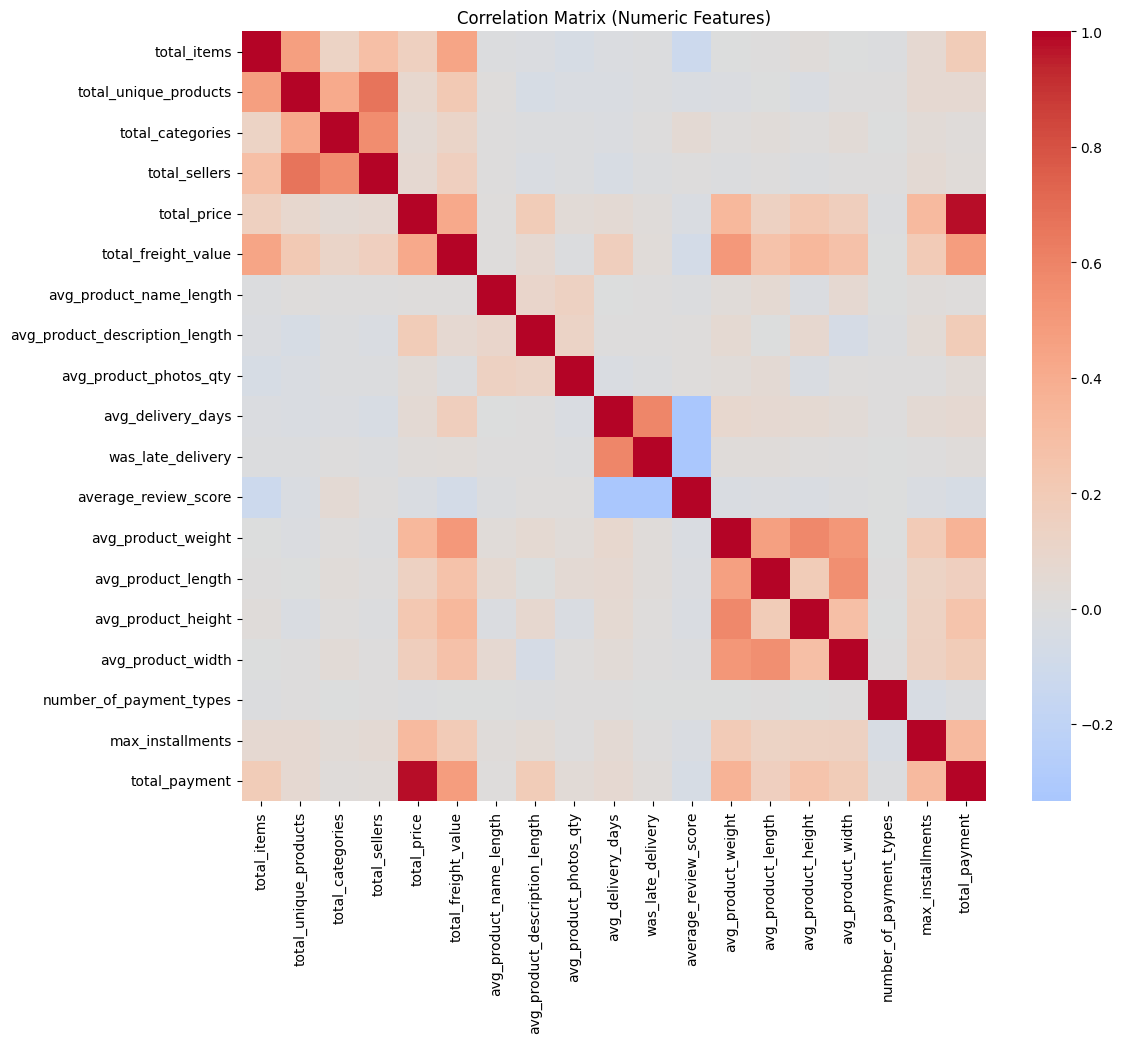

In [ ]:
# Correlation matrix for numeric variables (initial check)
corr_matrix = merged_payment_df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

#3. Missing Value Checking

## 1st iteration of missing value checking

In [ ]:
#1st iteration of missing value checking
# Count missing values for each column,
missing_values = merged_payment_df.isnull().sum()

# Calculate percentage of missing values,
missing_percent = (missing_values / len(merged_payment_df)) * 100

# Combine into a clean summary table,
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent (%)': missing_percent.round(2)
})

# Only display columns with at least 1 missing value,
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

# Sort by most missing values,
missing_summary.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percent (%)
avg_delivery_days,2965,2.98
order_delivered_customer_date,2965,2.98
avg_product_photos_qty,2164,2.18
avg_product_description_length,2164,2.18
avg_product_name_length,2164,2.18
order_delivered_carrier_date,1783,1.79
avg_product_height,791,0.80
avg_product_length,791,0.80
avg_product_weight,791,0.80
avg_product_width,791,0.80


## 2nd iteration of missing value checking

In [ ]:
# Missing value treatment & 2nd iteration of missing value checking
# Drop columns with missing values
merged_payment_df_cleaned = merged_payment_df.dropna(subset=[
    'average_review_score',
    'number_of_payment_types',
    'main_payment_type',
    'max_installments',
    'total_payment'])

# Count missing values for each column,
missing_values = merged_payment_df_cleaned.isnull().sum()

# Calculate percentage of missing values,
missing_percent = (missing_values / len(merged_payment_df_cleaned)) * 100

# Combine into a clean summary table,
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent (%)': missing_percent.round(2)
})

# Only display columns with at least 1 missing value,
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

# Sort by most missing values,
missing_summary.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percent (%)
order_delivered_customer_date,2843,2.88
avg_delivery_days,2843,2.88
avg_product_name_length,2135,2.16
avg_product_description_length,2135,2.16
avg_product_photos_qty,2135,2.16
order_delivered_carrier_date,1746,1.77
avg_product_height,772,0.78
avg_product_weight,772,0.78
avg_product_width,772,0.78
avg_product_length,772,0.78


In [ ]:
# Treatment of missing value from 2nd iteration
# Input (-1) for observations that has missing value of average delivery days and total items
merged_payment_df_cleaned['avg_delivery_days'] = merged_payment_df_cleaned['avg_delivery_days'].fillna(-1)
merged_payment_df_cleaned['total_items'] = merged_payment_df_cleaned['total_items'].fillna(-1)

# Drop columns with datatime variables
merged_payment_df_cleaned.drop(columns=['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at'], inplace=True)

<ipython-input-15-28c53e9a3707>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_payment_df_cleaned['avg_delivery_days'] = merged_payment_df_cleaned['avg_delivery_days'].fillna(-1)
<ipython-input-15-28c53e9a3707>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_payment_df_cleaned['total_items'] = merged_payment_df_cleaned['total_items'].fillna(-1)
<ipython-input-15-28c53e9a3707>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

## 3rd iteration of missing value checking

In [ ]:
# Missing value imputation and 3rd iteration of missing value checking
# Count missing values for each column,
missing_values = merged_payment_df_cleaned.isnull().sum()

# Calculate percentage of missing values,
missing_percent = (missing_values / len(merged_payment_df_cleaned)) * 100

# Combine into a clean summary table,
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent (%)': missing_percent.round(2)
})

# Only display columns with at least 1 missing value,
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

# Sort by most missing values,
missing_summary.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percent (%)
avg_product_name_length,2135,2.16
avg_product_description_length,2135,2.16
avg_product_photos_qty,2135,2.16
avg_product_weight,772,0.78
avg_product_length,772,0.78
avg_product_height,772,0.78
avg_product_width,772,0.78


In [ ]:
# Missing value imputation from the 3rd iteration of missing value checking
columns_to_impute = [
    'avg_product_name_length',
    'avg_product_description_length',
    'avg_product_photos_qty',
    'avg_product_weight',
    'avg_product_height',
    'avg_product_length',
    'avg_product_width'
]

for col in columns_to_impute:
    median_value = merged_payment_df_cleaned[col].median()
    merged_payment_df_cleaned[col] = merged_payment_df_cleaned[col].fillna(median_value)

<ipython-input-17-1ae90ff71910>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_payment_df_cleaned[col] = merged_payment_df_cleaned[col].fillna(median_value)


## 4th iteration of missing value checking

In [ ]:
# 4th iteration of missing value checking
# Count missing values for each column,
missing_values = merged_payment_df_cleaned.isnull().sum()

# Calculate percentage of missing values,
missing_percent = (missing_values / len(merged_payment_df_cleaned)) * 100

# Combine into a clean summary table,
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent (%)': missing_percent.round(2)
})

# Only display columns with at least 1 missing value,
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

# Sort by most missing values,
missing_summary.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percent (%)


#4. Feature Engineering for Predictors and Target Variable

In [ ]:
# Create a copy data frame
df = merged_payment_df_cleaned.copy()

# Check the count of target variable (average review socore)
df['average_review_score'].value_counts()

,count
average_review_score,
5.000000,56955
4.000000,19018
1.000000,11315
3.000000,8136
2.000000,3125
4.500000,54
2.500000,34
3.500000,25
1.500000,8


In [ ]:
# Transform review score into binary variables (1 if the score is >= 4 [satisfied], otherwise 0)
df['review_score_binary'] = df['average_review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Save into .csv file
df.to_csv("df_final.csv")

Percentage of Less satistifed customers (rating < 4): 22.95
Percentage of Satistifed customers (rating >= 4): 77.05


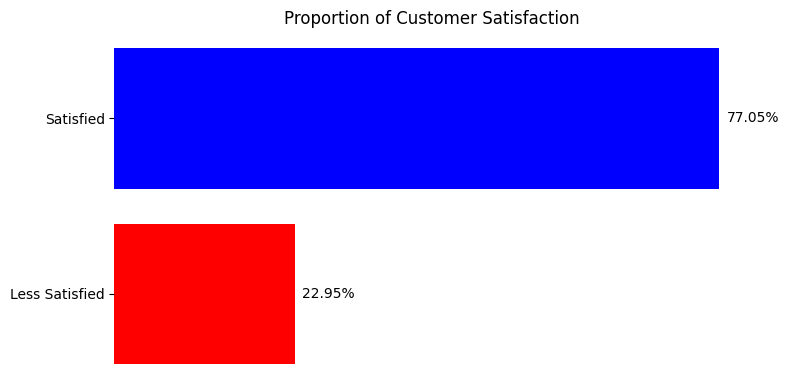

In [ ]:
# Visualise the distribution of target variable
# Calculate percent of 0 and 1
percent_0 = (df['review_score_binary'] == 0).mean() * 100
percent_1 = (df['review_score_binary'] == 1).mean() * 100

print('Percentage of Less satistifed customers (rating < 4): {:.2f}'.format(percent_0))
print('Percentage of Satistifed customers (rating >= 4): {:.2f}'.format(percent_1))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Review Score': ['Less Satisfied', 'Satisfied'],
    'Percentage': [percent_0, percent_1]
})

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
bars = plt.barh(plot_df['Review Score'], plot_df['Percentage'], color=['red', 'blue'])

# Remove x-axis
plt.gca().xaxis.set_visible(False)

# Add percentage labels on the right side
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center')

# Remove the outline (box)
plt.box(False)


plt.title('Proportion of Customer Satisfaction')
#plt.ylabel('Review Score Category')
plt.tight_layout()
plt.show()

<ipython-input-22-6d7e10b9bf38>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='was_late_delivery', y='review_score_binary', data=late_delivery_satisfaction, palette='viridis')


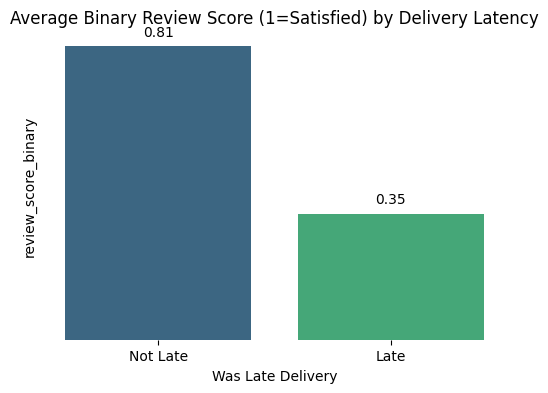

In [ ]:
# Relationship Graph for `review_score_binary` and `was_late_delivery`

# Calculate the mean of `review_score_binary` for each value of `was_late_delivery`
# 0 for not late, 1 for late
late_delivery_satisfaction = df.groupby('was_late_delivery')['review_score_binary'].mean().reset_index()

# Map the late delivery values to descriptive labels
late_delivery_satisfaction['was_late_delivery'] = late_delivery_satisfaction['was_late_delivery'].map({0: 'Not Late', 1: 'Late'})

# Create the bar plot
plt.figure(figsize=(6, 4))
bars = sns.barplot(x='was_late_delivery', y='review_score_binary', data=late_delivery_satisfaction, palette='viridis')

plt.title('Average Binary Review Score (1=Satisfied) by Delivery Latency')
plt.xlabel('Was Late Delivery')
# plt.ylabel('Average Binary Review Score (1=Satisfied)')
plt.yticks([])
# plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for clarity
# Remove the outline (box)
plt.box(False)


# Add percentage labels on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

In [ ]:

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Display duplicate rows if any
if duplicate_rows > 0:
    print("Duplicate rows:")
    print(df[df.duplicated(keep=False)])

# Check for inconsistent values in categorical columns (example)
# For 'order_status'
print("\nValue counts for 'order_status':")
print(df['order_status'].value_counts())

# For 'main_payment_type'
print("\nValue counts for 'main_payment_type':")
print(df['main_payment_type'].value_counts())

# For 'customer_state'
print("\nValue counts for 'customer_state':")
print(df['customer_state'].value_counts().head()) # Display top states

# You can add more checks for other categorical or potentially inconsistent columns
# For numerical columns, you might look at descriptive statistics to spot outliers or unusual values.
print("\nDescriptive statistics for numerical columns:")
print(df.describe())

# Example: Check for unusual values in 'total_payment'
print("\nOrders with very high total_payment:")
print(df[df['total_payment'] > df['total_payment'].quantile(0.99)].head()) # Orders above 99th percentile

# Example: Check for unusual values in 'avg_delivery_days'
print("\nOrders with very long average_delivery_days:")
print(df[df['avg_delivery_days'] > df['avg_delivery_days'].quantile(0.99)].head()) # Orders above 99th percentile


Number of duplicate rows: 0

Value counts for 'order_status':
order_status
delivered      95831
shipped         1032
canceled         605
unavailable      595
invoiced         309
processing       295
created            3
approved           2
Name: count, dtype: int64

Value counts for 'main_payment_type':
main_payment_type
credit_card    74391
boleto         19636
voucher         3121
debit_card      1521
not_defined        3
Name: count, dtype: int64

Value counts for 'customer_state':
customer_state
SP    41471
RJ    12687
MG    11554
RS     5443
PR     5019
Name: count, dtype: int64

Descriptive statistics for numerical columns:
        total_items  total_unique_products  total_categories  total_sellers  \
count  98672.000000           98672.000000      98672.000000   98672.000000   
mean       1.124422               1.029948          0.985842       1.005817   
min       -1.000000               0.000000          0.000000       0.000000   
25%        1.000000               1.000000 

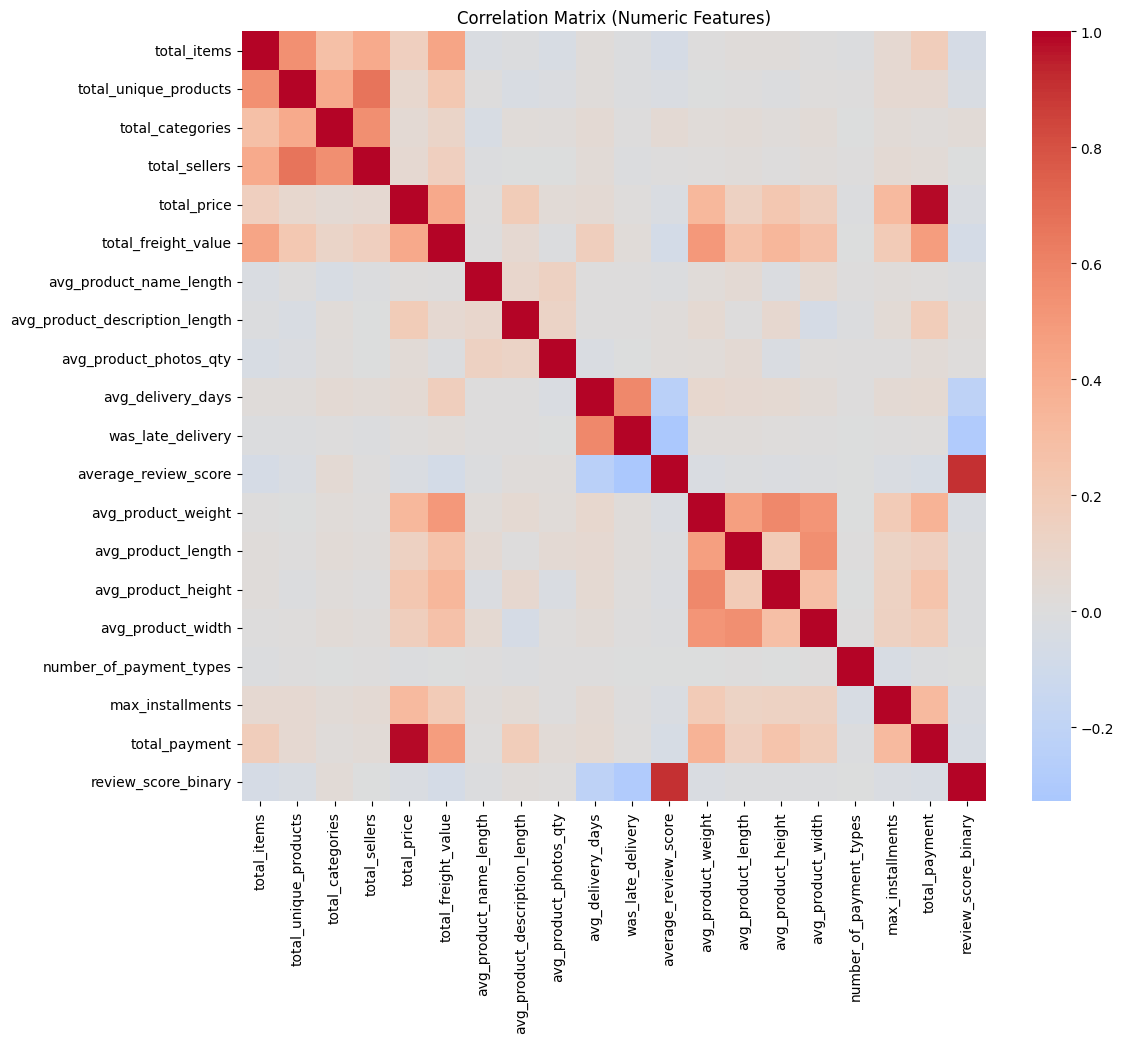

In [ ]:
# Correlation matrix for numeric variables (after data cleaning)
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

## Specify X (predictors) and Y (target variable)

In [ ]:
columns_to_exclude = [
'order_id', 'customer_unique_id', 'order_purchase_timestamp', 'order_estimated_delivery_date', 'average_review_score',
                       'total_sellers','total_unique_products','total_payment', 'total_categories', 'customer_city',
                       'review_score_binary', 'avg_product_name_length', 'number_of_payment_types'
]

# Drop target and identifiers
X = df.drop(columns=columns_to_exclude)
y = df['review_score_binary']

In [ ]:
# Encode all object columns (including order_status)
X_encoded = pd.get_dummies(X, drop_first=True)

X_encoded.shape

(98672, 49)

In [ ]:
# Check variable with string dtype
X.select_dtypes(include='object').nunique().sort_values(ascending=False)

,0
customer_state,27
order_status,8
main_payment_type,5


In [ ]:
# Encode string variable to a dummy numeric variables
X = X_encoded

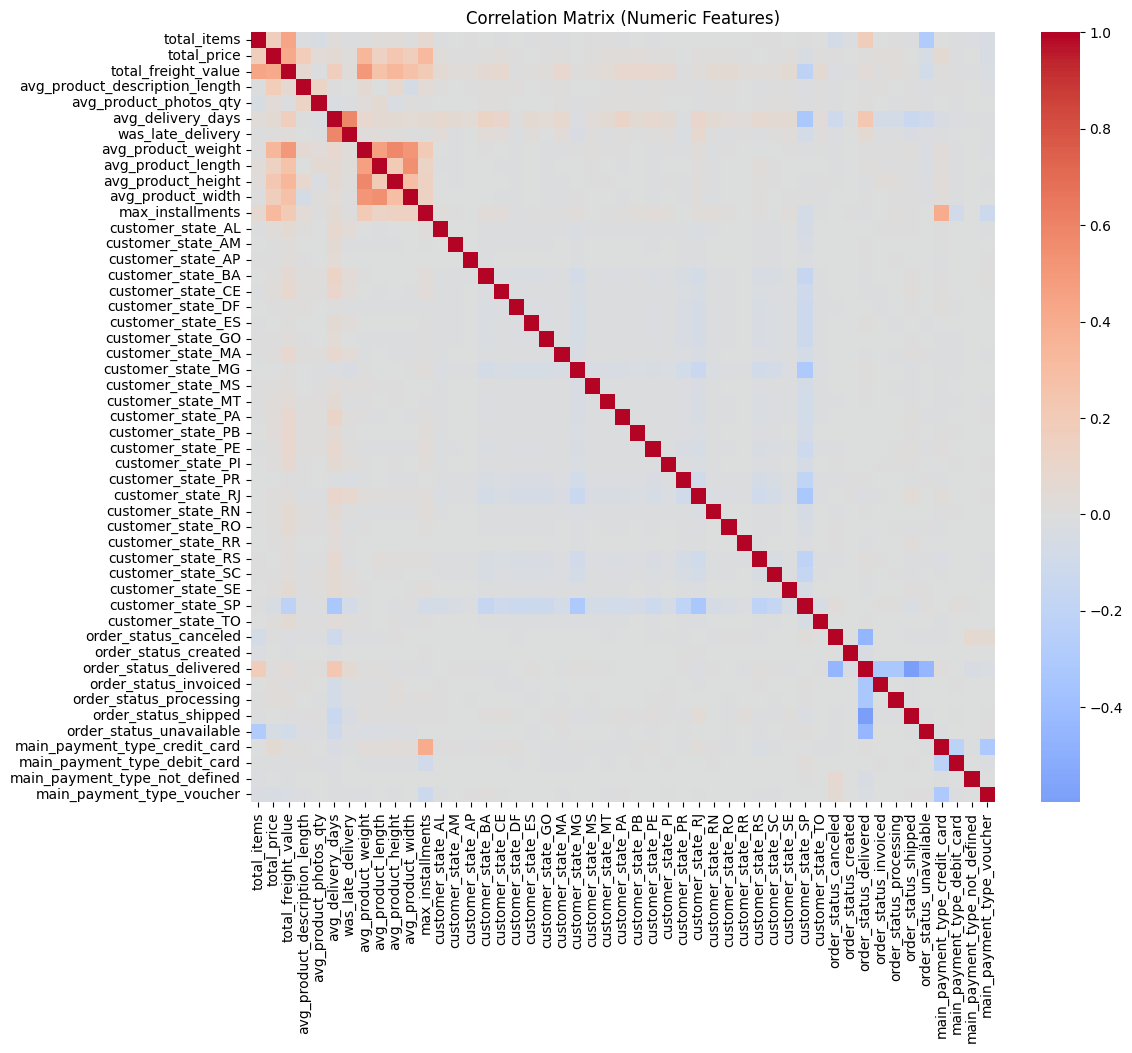

In [ ]:
# Correlation matrix for numeric variables (to check relationship with target variable)
corr_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

In [ ]:
# Calculate VIF to check dependency between independent variabels
# Step 1: Keep only numeric columns
X_vif = X.select_dtypes(include=[np.number])

# Step 2: Drop any columns with NaN or Inf just in case
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()

# Step 3: Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Step 4: Display
print(vif_data.sort_values(by="VIF", ascending=False))

                           feature       VIF
10               avg_product_width  7.137626
8               avg_product_length  6.578371
0                      total_items  5.217205
2              total_freight_value  4.092689
9               avg_product_height  3.596578
5                avg_delivery_days  3.593700
7               avg_product_weight  2.957486
4           avg_product_photos_qty  2.506028
3   avg_product_description_length  2.437158
11                max_installments  2.375614
1                      total_price  1.943589
6                was_late_delivery  1.636927


# 5. Machine Learing Algorithms

## Dataset train and test splitting

In [ ]:
# First split into train and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Then split temp into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42
)

## Baseline model

In [ ]:
# Define baseline models (untuned)
baseline_models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Store results
baseline_results = []

# Evaluate each baseline model
for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    baseline_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, zero_division=0),
        'Recall': recall_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'AUC': roc_auc_score(y_val, y_prob),
        'Log Loss': log_loss(y_val, y_prob)
    })

# Create DataFrame
baseline_df = pd.DataFrame(baseline_results).round(6)
print("\nBaseline Model Evaluation Summary:\n")
print(baseline_df.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:48:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 42575, number of negative: 12680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1725
[LightGBM] [Info] Number of data points in the train set: 55255, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.770519 -> initscore=1.211241
[LightGBM] [Info] Start training from score 1.211241

Baseline Model Evaluation Summary:

              Model  Accuracy  Precision   Recall  F1 Score      AUC  Log Loss
Logistic Regression  0.817921   0.827282 0.965200  0.890935 0.727911  0.457731
      Random Forest  0.812727   0.825785 0.959336  0.887565 0.719073  0.488179
            XGBoost  0.815725   0.826306 0.963336  0.889575 0.732833  0.455915
           LightGBM  0.818723   0.824632 0.971283  0.891970 0.737750  0.448065
           C

In [ ]:
# Check the baseline model dataframe
baseline_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Log Loss
0,Logistic Regression,0.817921,0.827282,0.965200,0.890935,0.727911,0.457731
1,Random Forest,0.812727,0.825785,0.959336,0.887565,0.719073,0.488179
2,XGBoost,0.815725,0.826306,0.963336,0.889575,0.732833,0.455915
3,LightGBM,0.818723,0.824632,0.971283,0.891970,0.737750,0.448065
4,CatBoost,0.819145,0.826659,0.968324,0.891901,0.740117,0.448113


## Best Single Model

In [ ]:
columns_to_exclude = [
'order_id', 'customer_unique_id', 'order_purchase_timestamp', 'order_estimated_delivery_date', 'average_review_score',
                       'total_sellers','total_unique_products','total_payment', 'total_categories', #'customer_city',
                       'review_score_binary', 'avg_product_name_length', 'number_of_payment_types'
]

# Drop target and identifiers
Xc = df.drop(columns=columns_to_exclude)
yc = df['review_score_binary']

In [ ]:
# Let CatBoost know which columns are categorical
cat_features = Xc.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical features:", cat_features)

Categorical features: ['customer_city', 'customer_state', 'order_status', 'main_payment_type']


In [ ]:
from sklearn.model_selection import train_test_split

# First split into temporary set and test set (20% for testing)
Xc_temp, Xc_test, yc_temp, yc_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)

# Then split the temporary set into train and validation (30% of remaining for validation)
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    Xc_temp, yc_temp, test_size=0.3, stratify=yc_temp, random_state=42
)

In [ ]:
from catboost import CatBoostClassifier

# Initialize and train the model
model = CatBoostClassifier(verbose=100, random_seed=42)
model.fit(Xc_train, yc_train, cat_features=cat_features)

# Predict and evaluate on validation set
yc_pred = model.predict(Xc_val)
yc_prob = model.predict_proba(Xc_val)[:, 1]

Learning rate set to 0.057138
0:	learn: 0.6654482	total: 102ms	remaining: 1m 42s
100:	learn: 0.4470868	total: 8.71s	remaining: 1m 17s
200:	learn: 0.4417098	total: 15.9s	remaining: 1m 3s
300:	learn: 0.4355693	total: 24.9s	remaining: 57.8s
400:	learn: 0.4305388	total: 34.7s	remaining: 51.8s
500:	learn: 0.4260124	total: 42.3s	remaining: 42.2s
600:	learn: 0.4220842	total: 54.7s	remaining: 36.3s
700:	learn: 0.4180607	total: 1m 3s	remaining: 27.3s
800:	learn: 0.4146007	total: 1m 13s	remaining: 18.2s
900:	learn: 0.4109426	total: 1m 20s	remaining: 8.89s
999:	learn: 0.4078450	total: 1m 36s	remaining: 0us


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Create results dictionary
catboost_result = {
    'Model': 'CatBoost (Default)',
    'Accuracy': accuracy_score(yc_val, yc_pred),
    'Precision': precision_score(yc_val, yc_pred, zero_division=0),
    'Recall': recall_score(yc_val, yc_pred),
    'F1 Score': f1_score(yc_val, yc_pred),
    'AUC': roc_auc_score(yc_val, yc_prob),
    'Log Loss': log_loss(yc_val, yc_prob)
}

# Convert to DataFrame
results_df = pd.DataFrame([catboost_result]).round(6)

results_df


,Model,Accuracy,Precision,Recall,F1 Score,AUC,Log Loss
0,CatBoost (Default),0.820032,0.826859,0.96942,0.892482,0.742195,0.446259


## Model Stacking

In [ ]:
# Define base learners (you can swap in tuned models if preferred)
base_learners = [
    ('lgbm', LGBMClassifier(random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define meta-learner (logistic regression is common and interpretable)
meta_learner = LogisticRegression(solver='liblinear', random_state=42)

# Create stacking ensemble
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Set to True to include original features in meta-learner
)

# Fit on training data
stacked_model.fit(X_train, y_train)

# Predict and evaluate on validation set
y_pred = stacked_model.predict(X_val)
y_prob = stacked_model.predict_proba(X_val)[:, 1]

# Evaluate performance
stacked_results = pd.DataFrame([{
    'Model': 'Stacked Model',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred, zero_division=0),
    'Recall': recall_score(y_val, y_pred),
    'F1 Score': f1_score(y_val, y_pred),
    'AUC': roc_auc_score(y_val, y_prob),
    'Log Loss': log_loss(y_val, y_prob)
}])

# Compare with existing results
all_results = pd.concat([baseline_df, stacked_results], ignore_index=True)
print("\nStacked Model Evaluation Summary:\n")
print(all_results.sort_values(by='AUC', ascending=False).round(6).to_string(index=False))



Stacked Model Evaluation Summary:

              Model  Accuracy  Precision   Recall  F1 Score      AUC  Log Loss
      Stacked Model  0.819061   0.825697 0.969913  0.892014 0.741518  0.448149
           CatBoost  0.819145   0.826659 0.968324  0.891901 0.740117  0.448113
           LightGBM  0.818723   0.824632 0.971283  0.891970 0.737750  0.448065
            XGBoost  0.815725   0.826306 0.963336  0.889575 0.732833  0.455915
Logistic Regression  0.817921   0.827282 0.965200  0.890935 0.727911  0.457731
      Random Forest  0.812727   0.825785 0.959336  0.887565 0.719073  0.488179


In [ ]:
all_results.sort_values(by='AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Log Loss
5,Stacked Model,0.819061,0.825697,0.969913,0.892014,0.741518,0.448149
4,CatBoost,0.819145,0.826659,0.968324,0.891901,0.740117,0.448113
3,LightGBM,0.818723,0.824632,0.971283,0.891970,0.737750,0.448065
2,XGBoost,0.815725,0.826306,0.963336,0.889575,0.732833,0.455915
0,Logistic Regression,0.817921,0.827282,0.965200,0.890935,0.727911,0.457731
1,Random Forest,0.812727,0.825785,0.959336,0.887565,0.719073,0.488179


In [ ]:
# Define the names in the same order as you passed to StackingClassifier
base_model_names = ['lgbm', 'catboost', 'xgb']

# Access meta-learner coefficients
meta_coef = stacked_model.final_estimator_.coef_.flatten()

# Combine into DataFrame
importance_df = pd.DataFrame({
    'Base Model': base_model_names,
    'Meta Coefficient': meta_coef
}).sort_values(by='Meta Coefficient', ascending=False)

print("\nMeta-Learner (Logistic Regression) Coefficients:\n")
print(importance_df.to_string(index=False))


Meta-Learner (Logistic Regression) Coefficients:

Base Model  Meta Coefficient
  catboost          2.941534
      lgbm          1.828607
       xgb          0.176366


Learning rate set to 0.057138
0:	learn: 0.6654482	total: 170ms	remaining: 2m 50s
100:	learn: 0.4470868	total: 7.51s	remaining: 1m 6s
200:	learn: 0.4417098	total: 16.2s	remaining: 1m 4s
300:	learn: 0.4355693	total: 26.8s	remaining: 1m 2s
400:	learn: 0.4305388	total: 34.5s	remaining: 51.5s
500:	learn: 0.4260124	total: 43.6s	remaining: 43.4s
600:	learn: 0.4220842	total: 52.7s	remaining: 35s
700:	learn: 0.4180607	total: 1m	remaining: 25.8s
800:	learn: 0.4146007	total: 1m 9s	remaining: 17.3s
900:	learn: 0.4109426	total: 1m 18s	remaining: 8.65s
999:	learn: 0.4078450	total: 1m 26s	remaining: 0us


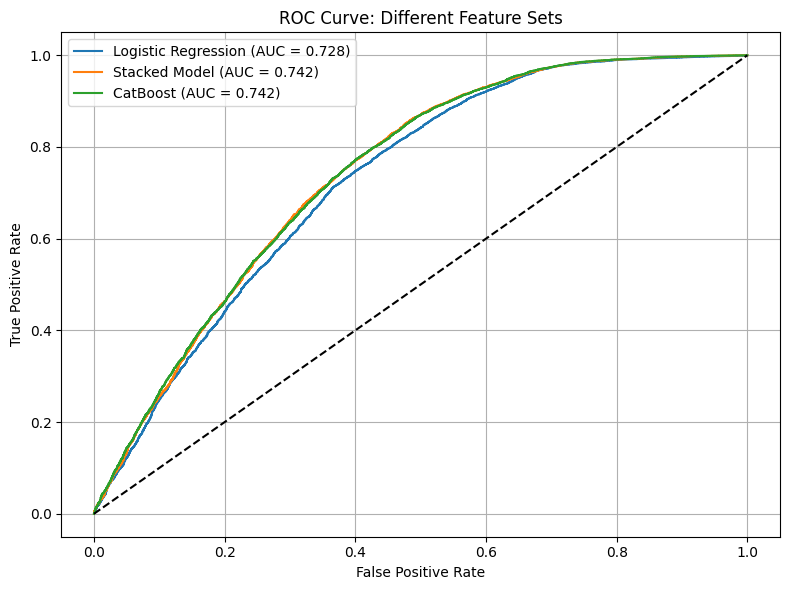

In [ ]:
# Logistic Regression and Stacked use X_train, X_val, y_train, y_val

# Define the models explicitly before using them
log_model = baseline_models['Logistic Regression']
stack_model = stacked_model # Assuming 'stacked_model' from the Model Stacking section is the intended stacked model

# CatBoost uses a different feature set
# Use the model trained in the 'Best Single Model' section
cat_model = model

log_model.fit(X_train, y_train)
stack_model.fit(X_train, y_train)

# CatBoost uses a different feature set
# Pass the cat_features list explicitly to the fit method
cat_model.fit(Xc_train, yc_train, cat_features=cat_features)

# Predict probabilities
log_prob = log_model.predict_proba(X_val)[:, 1]
stack_prob = stack_model.predict_proba(X_val)[:, 1]
# Predict probabilities for CatBoost using the correctly identified categorical features
cat_prob = cat_model.predict_proba(Xc_val)[:, 1]

# Import necessary metrics for plotting ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure you're using the correct y_val for each model
# Assuming yc_val == y_val semantically (even if stored separately)
fpr_log, tpr_log, _ = roc_curve(y_val, log_prob)
fpr_stack, tpr_stack, _ = roc_curve(y_val, stack_prob)
fpr_cat, tpr_cat, _ = roc_curve(yc_val, cat_prob)

# AUCs
auc_log = auc(fpr_log, tpr_log)
auc_stack = auc(fpr_stack, tpr_stack)
auc_cat = auc(fpr_cat, tpr_cat)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.3f})')
plt.plot(fpr_stack, tpr_stack, label=f'Stacked Model (AUC = {auc_stack:.3f})')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_cat:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Different Feature Sets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Tuning model hyperparameter

In [ ]:
!pip install optuna

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "eval_metric": "AUC",
        "verbose": 0,
        "random_seed": 42,
        "task_type": "CPU",  # Change to "GPU" if applicable
        "cat_features": cat_features
    }

    model = CatBoostClassifier(**params)
    model.fit(Xc_train, yc_train, eval_set=(Xc_val, yc_val), early_stopping_rounds=50)

    yc_val_pred = model.predict_proba(Xc_val)[:, 1]
    auc = roc_auc_score(yc_val, yc_val_pred)
    return auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # You can increase the number for better tuning

In [ ]:
print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

In [ ]:
best_params = study.best_params
best_params.update({
    "eval_metric": "AUC",
    "verbose": 100,
    "random_seed": 42,
    "cat_features": cat_features
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(Xc_train, yc_train, eval_set=(Xc_val, yc_val))

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss
)
import pandas as pd

# Predict on validation set
yc_pred = best_model.predict(Xc_val)
yc_prob = best_model.predict_proba(Xc_val)[:, 1]

# Store evaluation metrics
tuned_result = {
    'Model': 'CatBoost (Tuned)',
    'Accuracy': accuracy_score(yc_val, yc_pred),
    'Precision': precision_score(yc_val, yc_pred, zero_division=0),
    'Recall': recall_score(yc_val, yc_pred),
    'F1 Score': f1_score(yc_val, yc_pred),
    'AUC': roc_auc_score(yc_val, yc_prob),
    'Log Loss': log_loss(yc_val, yc_prob)
}

# Convert to DataFrame
results_df = pd.DataFrame([tuned_result]).round(6)

# Display the table
from IPython.display import display
display(results_df)


0:	total: 150ms	remaining: 1m 36s
100:	total: 10.2s	remaining: 54.6s
200:	total: 15.5s	remaining: 34.1s
300:	total: 22.5s	remaining: 25.5s
400:	total: 28s	remaining: 16.9s
500:	total: 34.9s	remaining: 9.88s
600:	total: 40.3s	remaining: 2.82s
642:	total: 42.6s	remaining: 0us


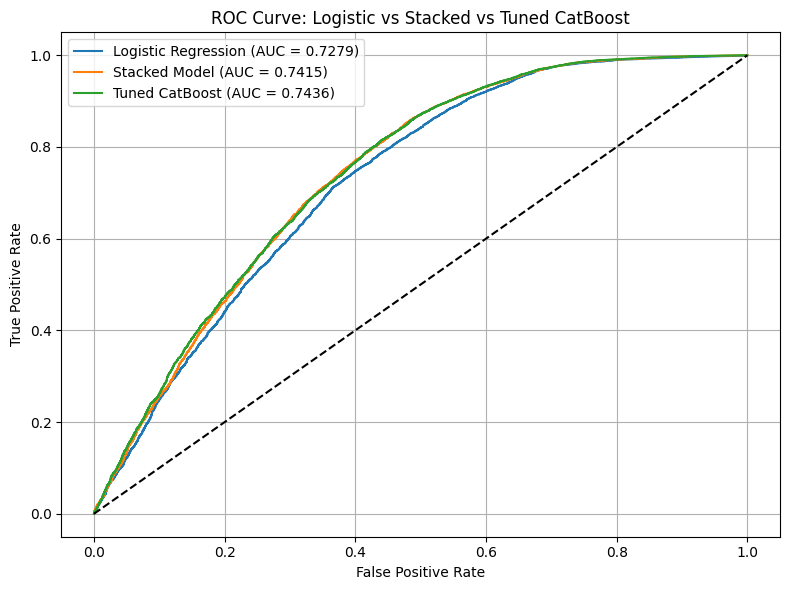

In [ ]:
from catboost import CatBoostClassifier

# Define tuned CatBoost with your best parameters
best_params = {
    'iterations': 643,
    'learning_rate': 0.138003538481454,
    'depth': 4,
    'l2_leaf_reg': 7.405520104654033,
    'random_strength': 0.9955539818105987,
    'bagging_temperature': 1.8750685876740536,
    'border_count': 157,
    'eval_metric': 'AUC',
    'verbose': 100,
    'random_seed': 42
}

# Instantiate tuned CatBoost model
tuned_catboost = CatBoostClassifier(**best_params)

# Fit on the specific feature set
tuned_catboost.fit(Xc_train, yc_train, cat_features=cat_features)

# Predict probabilities
cat_prob = tuned_catboost.predict_proba(Xc_val)[:, 1]

# Compute ROC components (assumes yc_val is the target for this model)
fpr_cat, tpr_cat, _ = roc_curve(yc_val, cat_prob)
auc_cat = auc(fpr_cat, tpr_cat)

# Add to existing ROC curve plot
plt.figure(figsize=(8, 6))

# Reuse predictions from other models (assumed already fitted)
log_prob = log_model.predict_proba(X_val)[:, 1]
stack_prob = stack_model.predict_proba(X_val)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_val, log_prob)
fpr_stack, tpr_stack, _ = roc_curve(y_val, stack_prob)
auc_log = auc(fpr_log, tpr_log)
auc_stack = auc(fpr_stack, tpr_stack)

# Plot all models
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.4f})')
plt.plot(fpr_stack, tpr_stack, label=f'Stacked Model (AUC = {auc_stack:.4f})')
plt.plot(fpr_cat, tpr_cat, label=f'Tuned CatBoost (AUC = {auc_cat:.4f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic vs Stacked vs Tuned CatBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Model explainability by SHAP value

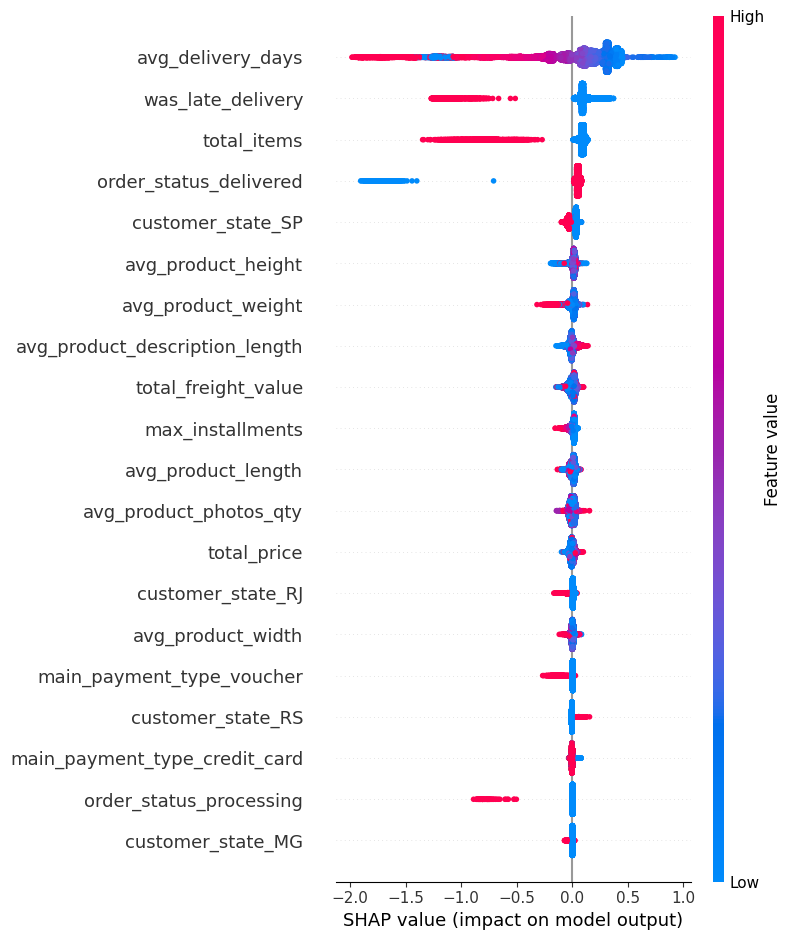

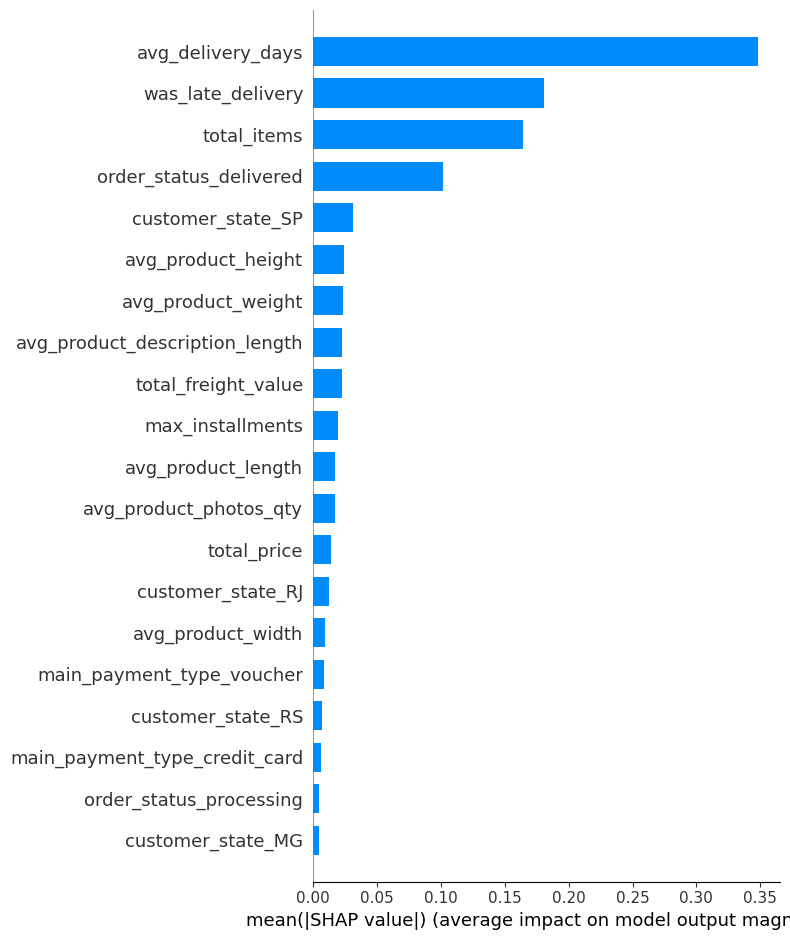


Top 10 Most Influential Features:

                       Feature  SHAP Importance
             avg_delivery_days         0.347979
             was_late_delivery         0.181040
                   total_items         0.164491
        order_status_delivered         0.101517
             customer_state_SP         0.031390
            avg_product_height         0.024264
            avg_product_weight         0.023207
avg_product_description_length         0.022929
           total_freight_value         0.022778
              max_installments         0.019607


In [ ]:
# 📚 Import Libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ⚙️ Create SHAP explainer for the tuned CatBoost model
explainer = shap.TreeExplainer(best_model)

# 📈 Compute SHAP values for validation set (or a sample for speed)
Xc_sample = Xc_val.sample(1000, random_state=42)  # Optional sampling
shap_values = explainer.shap_values(Xc_sample)

# 📊 Global Feature Importance: SHAP Beeswarm Plot
shap.summary_plot(shap_values, Xc_sample, plot_type="dot")

# 📊 SHAP Bar Plot (for slide presentation)
shap.summary_plot(shap_values, Xc_sample, plot_type="bar")

# 📥 Save SHAP importance values to DataFrame
shap_importance = pd.DataFrame({
    'Feature': Xc_sample.columns,
    'SHAP Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP Importance', ascending=False)

# Show Top 10 Important Features
print("\nTop 10 Most Influential Features (Tuned CatBoost):\n")
print(shap_importance.head(10).to_string(index=False))

# 🔍 Local Explanation for One Sample
shap.initjs()
i = 0  # Index in Xc_sample
shap.force_plot(explainer.expected_value, shap_values[i], Xc_sample.iloc[i])

In [ ]:
# Combine predictions, probabilities, and original features
val_df = Xc_val.copy()
val_df['true_label'] = yc_val
val_df['predicted_label'] = yc_pred
val_df['predicted_prob'] = yc_prob

# Check average predicted satisfaction by order status
grouped_stats = val_df.groupby('order_status').agg({
    'true_label': ['mean', 'count'],
    'predicted_prob': 'mean',
    'predicted_label': 'mean'
}).rename(columns={
    'mean': 'Avg Value',
    'count': 'Count'
})

# Flatten column names
grouped_stats.columns = ['True_Label_Mean', 'Sample_Size', 'Predicted_Prob_Mean', 'Predicted_Label_Mean']
grouped_stats = grouped_stats.reset_index()

# Display
from IPython.display import display
display(grouped_stats.sort_values('Predicted_Prob_Mean'))


In [ ]:
# Group by customer_state and compute aggregated statistics
state_stats = val_df.groupby('customer_state').agg({
    'true_label': ['mean', 'count'],
    'predicted_prob': 'mean',
    'predicted_label': 'mean'
}).rename(columns={
    'mean': 'Avg Value',
    'count': 'Count'
})

# Flatten multi-index column names
state_stats.columns = ['True_Label_Mean', 'Sample_Size', 'Predicted_Prob_Mean', 'Predicted_Label_Mean']
state_stats = state_stats.reset_index()

# Sort by actual satisfaction level (true label mean)
state_stats = state_stats.sort_values('True_Label_Mean')

# Display
from IPython.display import display
display(state_stats)


Logistic Regression model is the most interpretable model. Analyse feature importance based on base Logistic Regression Model

In [ ]:
# Access the trained logistic regression model
logreg_model = baseline_models['Logistic Regression']

# Get coefficients and feature names
coef = logreg_model.coef_.flatten()
feature_names = X_train.columns

# Combine into a DataFrame for easy viewing
logreg_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
}).sort_values(by='Coefficient', ascending=False)

# Display top 10 positive and negative coefficients
print("🔼 Top 10 Features that Increase Likelihood of Satisfaction:")
print(logreg_coefficients.head(10).to_string(index=False))

print("\n🔽 Top 10 Features that Decrease Likelihood of Satisfaction:")
print(logreg_coefficients.tail(10).to_string(index=False))


🔼 Top 10 Features that Increase Likelihood of Satisfaction:
                     Feature  Coefficient
      order_status_delivered     3.111263
           customer_state_MT     0.121658
           customer_state_PB     0.101182
           customer_state_RN     0.085067
           customer_state_TO     0.084431
           customer_state_MS     0.072379
           customer_state_PA     0.067040
           customer_state_AM     0.064332
           customer_state_PE     0.059289
main_payment_type_debit_card     0.058151

🔽 Top 10 Features that Decrease Likelihood of Satisfaction:
                  Feature  Coefficient
        customer_state_MG    -0.278589
        customer_state_SP    -0.285352
main_payment_type_voucher    -0.382524
              total_items    -0.397371
    order_status_invoiced    -0.415355
  order_status_processing    -0.481539
     order_status_shipped    -0.709613
    order_status_canceled    -0.762578
 order_status_unavailable    -1.123948
        was_late_delivery  

## Robustness and Generalization

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

# Define tuned CatBoost model using best Optuna parameters
tuned_catboost = CatBoostClassifier(
    iterations=643,
    learning_rate=0.138003538481454,
    depth=4,
    l2_leaf_reg=7.405520104654033,
    random_strength=0.9955539818105987,
    bagging_temperature=1.8750685876740536,
    border_count=157,
    eval_metric='AUC',
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define evaluation metrics
metrics = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1 Score': 'f1',
    'AUC': 'roc_auc'
}

# Run cross-validation and collect results
cv_results = {}
for name, scoring in metrics.items():
    scores = cross_val_score(tuned_catboost, Xc, yc, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results[name] = {
        'Mean CV Score': round(np.mean(scores), 4),
        'Standard Deviation': round(np.std(scores), 4)
    }

# Display results
cv_results_df = pd.DataFrame(cv_results).T
print("\nCatBoost (Tuned) 5-Fold Cross-Validation Results:\n")
print(cv_results_df)


In [ ]:
# Install libraries if needed
!pip install catboost lightgbm xgboost

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics
metrics = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1 Score': 'f1',
    'AUC': 'roc_auc'
}

# Logistic Regression
logreg_model = LogisticRegression(solver='liblinear', random_state=42)

# Stacking model
stacked_model = StackingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(random_state=42)),
        ('catboost', CatBoostClassifier(verbose=0, random_seed=42)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ],
    final_estimator=LogisticRegression(solver='liblinear', random_state=42),
    cv=5,
    n_jobs=-1
)

# Function to evaluate with CV
def evaluate_model(model, model_name):
    results = {}
    for metric_name, scoring in metrics.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        results[metric_name] = {
            'Model': model_name,
            'Mean CV Score': round(np.mean(scores), 4),
            'Std Dev': round(np.std(scores), 4)
        }
    return pd.DataFrame(results).T

# Run CV
logreg_results = evaluate_model(logreg_model, 'Logistic Regression')
stacked_results = evaluate_model(stacked_model, 'Stacked Model')

# Optional: add CatBoost (untuned) if not rerunning
catboost_results = pd.DataFrame({
    'Model': 'CatBoost (Untuned)',
    'Mean CV Score': [0.8200, 0.8265, 0.9699, 0.8925, 0.7389],
    'Std Dev': [0.0024, 0.0013, 0.0020, 0.0014, 0.0043]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Combine results
cv_comparison = pd.concat([logreg_results, catboost_results, stacked_results])
cv_comparison.index.name = 'Metric'

# Display result
print("\n5-Fold Cross-Validation Results:\n")
print(cv_comparison)


## Error Analysis

In [ ]:
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier

# Fit the model (only if not trained already)
tuned_catboost.fit(Xc_train, yc_train)

# Predict and compute confusion matrix
yc_pred_catboost = tuned_catboost.predict(Xc_val)
cm_catboost = confusion_matrix(yc_val, yc_pred_catboost)
print("Confusion Matrix – Tuned CatBoost:\n", cm_catboost)


In [ ]:
from sklearn.metrics import confusion_matrix

# 1. Logistic Regression
y_pred_logreg = baseline_models['Logistic Regression'].predict(X_val)
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
print("Confusion Matrix – Logistic Regression:\n", cm_logreg)

# 2. Stacked Model
y_pred_stack = stacked_model.predict(X_val)
cm_stack = confusion_matrix(y_val, y_pred_stack)
print("\nConfusion Matrix – Stacked Model:\n", cm_stack)

## Business Implication Analysis

In [ ]:
import pandas as pd

# Define models
models = ['Logistic Regression', 'CatBoost (Tuned)', 'Stacked Model']

# Business cost assumptions (in BRL)
recovery_cost = 80                    # Cost to act on dissatisfaction (e.g., offer, support)
loss_per_dissatisfied = 160          # Estimated loss from unhandled dissatisfaction

# Simulated confusion matrix results: [TN, FP, FN, TP]
conf_matrix = {
    'Logistic Regression': [1771, 3664, 670, 17577],
    'CatBoost (Tuned)': [1737, 3698, 563, 17684],
    'Stacked Model': [1699, 3736, 549, 17698]
}

# Compute business KPIs
results = []
for model in models:
    tn, fp, fn, tp = conf_matrix[model]

    # Business metrics
    retained_value = tp * loss_per_dissatisfied      # Value from retaining unhappy customers
    missed_loss = fn * loss_per_dissatisfied         # Loss from missed dissatisfied customers
    wasted_effort = fp * recovery_cost               # Cost of unnecessary recovery outreach
    total_intervention_cost = missed_loss + wasted_effort
    net_impact = retained_value - total_intervention_cost
    roi = (retained_value / total_intervention_cost) if total_intervention_cost > 0 else float('inf')

    results.append({
        'Model': model,
        'Retained Value (R$)': retained_value,
        'Missed Loss (R$)': missed_loss,
        'Wasted Effort (R$)': wasted_effort,
        'Total Intervention Cost (R$)': total_intervention_cost,
        'Net Business Impact (R$)': net_impact,
        'ROI': round(roi, 2)
    })

# Create and display summary DataFrame
impact_df_brl = pd.DataFrame(results)
impact_df_brl

,Model,Retained Value (R$),Missed Loss (R$),Wasted Effort (R$),Total Intervention Cost (R$),Net Business Impact (R$),ROI
0,Logistic Regression,2812320,107200,293120,400320,2412000,7.03
1,CatBoost (Tuned),2829440,90080,295840,385920,2443520,7.33
2,Stacked Model,2831680,87840,298880,386720,2444960,7.32


# Conclusion
The process of building machine learning model considered several alternatives of algorithms, resulting CatBoost as a single best performance to predict customer satisfaction (bases on rating score) from various predictors (both numeric and categorical). The model then tuned to achive better performance, and able to interpreted by using SHAP value. Model stacking with LightGBM, XGBoost, and CatBoost as base learners, and Logistics Regression as meta learning is able to improve performance. However, the computing time and resources needed to compute the model does not align with the increment improvement.